In [113]:
import sys
import pandas as pd
import pickle
import joblib
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle
import joblib
import glob
import os

from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from imblearn.over_sampling import RandomOverSampler

from keras import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.regularizers import l2
from keras.wrappers.scikit_learn import KerasClassifier

print(sys.version)

3.8.5 (default, Jan 27 2021, 15:41:15) 
[GCC 9.3.0]


In [114]:
# train original data
# curr_dir = os.path.dirname(os.path.realpath(__file__))
# df_train = pd.read_csv(os.path.join(curr_dir, 'backup_orignal_data', 'dataset_train_NASDAQ100.csv'))
# df_test = pd.read_csv(os.path.join(curr_dir, 'backup_orignal_data', 'dataset_test_sp500.csv'))
# df_train

In [115]:
# train with the latest data
__file__ = 'build_ML_model.ipynb'
curr_dir = os.path.dirname(os.path.realpath(__file__))
list_of_training_set_files = glob.glob(os.path.join(curr_dir, 'dataset', 'S&P500-Symbols[0-9]*.csv'))
latest_data_train_file = max(list_of_training_set_files, key=os.path.getctime)
print(f'TRAINING SET FILE: {latest_data_train_file}')

list_of_test_set_files = glob.glob(os.path.join(curr_dir, 'dataset', 'NASDAQ100-Symbols[0-9]*.csv'))
latest_data_test_file = max(list_of_test_set_files, key=os.path.getctime)
print(f'TEST SET FILE: {latest_data_test_file}')

df_train = pd.read_csv(latest_data_train_file)
df_test = pd.read_csv(latest_data_test_file)

df_train

TRAINING SET FILE: /home/thomas/Desktop/capstone_project/backend/stocks/webscraper/dataset/S&P500-Symbols21_03_16-171740.csv
TEST SET FILE: /home/thomas/Desktop/capstone_project/backend/stocks/webscraper/dataset/NASDAQ100-Symbols21_03_16-181534.csv


,Symbol,open,52_wk_low,52_wk_hi,volume,avg_volume,market_cap,PE_ratio,EPS_ratio,target
0,MMM,188.00,114.04,189.63,1976087.0,2701328.0,1.082050e+11,20.20,9.25,NaN
1,ABT,118.45,61.61,128.54,3016030.0,4985537.0,2.094300e+11,47.23,2.50,Undervalued
2,ABBV,109.95,62.55,113.41,4065210.0,7065142.0,1.957300e+11,40.75,2.72,Overvalued
3,ABMD,309.03,119.01,387.40,476158.0,345525.0,1.396200e+10,70.36,4.39,Undervalued
4,ACN,267.22,137.15,271.18,1946523.0,2044428.0,1.742220e+11,32.44,8.12,Overvalued
...,...,...,...,...,...,...,...,...,...,...
500,YUM,108.00,54.95,110.66,2230596.0,1766574.0,3.264600e+10,37.01,2.94,Overvalued
501,ZBRA,481.19,163.44,516.79,238138.0,384345.0,2.533800e+10,50.68,9.35,Overvalued
502,ZBH,161.00,74.37,170.05,983199.0,1276825.0,3.330900e+10,NaN,-0.67,Overvalued
503,ZION,57.17,23.58,59.37,1048670.0,1455542.0,9.262000e+09,18.68,3.02,Overvalued


In [116]:
df_test

,Symbol,open,52_wk_low,52_wk_hi,volume,avg_volume,market_cap,PE_ratio,EPS_ratio,target
0,ATVI,93.56,50.51,104.53,4552788.0,5846123.0,7.226900e+10,33.08,2.82,Undervalued
1,ADBE,452.01,255.13,536.88,2528657.0,2632633.0,2.159560e+11,41.60,10.83,Undervalued
2,AMD,83.66,36.75,99.23,42971552.0,43073091.0,1.002370e+11,40.09,2.06,Undervalued
3,ALXN,154.20,75.57,162.60,4655730.0,3017306.0,3.371800e+10,56.39,2.72,Undervalued
4,ALGN,566.41,127.88,634.46,482020.0,585757.0,4.293300e+10,24.21,22.41,Undervalued
...,...,...,...,...,...,...,...,...,...,...
97,WBA,55.00,33.36,56.11,7013099.0,6499466.0,4.727200e+10,NaN,-0.80,Overvalued
98,WDAY,256.67,107.75,282.77,1590883.0,2166076.0,6.245400e+10,NaN,-1.19,Overvalued
99,XEL,62.98,46.58,76.44,3053305.0,2712115.0,3.409200e+10,22.73,2.79,Overvalued
100,XLNX,130.06,68.02,154.93,2264333.0,2610876.0,3.174700e+10,51.69,2.50,Overvalued


In [117]:
# perform preprocessing data before they can be used

# drop near fair value
df_train_drop_fair_value = df_train[df_train['target'] != 'Near Fair Value']
df_test_drop_fair_value = df_test[df_test['target'] != 'Near Fair Value']
# print(df_test_drop_na['target'])

# removing N/A
df_train_drop_na = df_train_drop_fair_value.dropna()
df_test_drop_na = df_test_drop_fair_value.dropna()

# remove intersection between two dataframes in test set
df_test_drop_na = pd.merge(df_test_drop_na, df_train_drop_na, how='outer', indicator=True).query('_merge=="left_only"').drop(['_merge'], axis=1)

# drop Symbol col
p_df_train = df_train_drop_na.drop(['Symbol', 'target'], axis=1)
p_df_test = df_test_drop_na.drop(['Symbol', 'target'], axis=1)

p_df_train

,open,52_wk_low,52_wk_hi,volume,avg_volume,market_cap,PE_ratio,EPS_ratio
1,118.45,61.61,128.54,3016030.0,4985537.0,2.094300e+11,47.23,2.50
2,109.95,62.55,113.41,4065210.0,7065142.0,1.957300e+11,40.75,2.72
3,309.03,119.01,387.40,476158.0,345525.0,1.396200e+10,70.36,4.39
4,267.22,137.15,271.18,1946523.0,2044428.0,1.742220e+11,32.44,8.12
5,93.56,50.51,104.53,4264816.0,5846123.0,7.226900e+10,33.08,2.82
...,...,...,...,...,...,...,...,...
499,103.76,54.62,108.84,725359.0,1080125.0,1.849800e+10,73.26,1.40
500,108.00,54.95,110.66,2230596.0,1766574.0,3.264600e+10,37.01,2.94
501,481.19,163.44,516.79,238138.0,384345.0,2.533800e+10,50.68,9.35
503,57.17,23.58,59.37,1048670.0,1455542.0,9.262000e+09,18.68,3.02


In [118]:
p_df_test

,open,52_wk_low,52_wk_hi,volume,avg_volume,market_cap,PE_ratio,EPS_ratio
0,93.56,50.51,104.53,4552788.0,5846123.0,7.226900e+10,33.08,2.82
2,83.66,36.75,99.23,42971552.0,43073091.0,1.002370e+11,40.09,2.06
3,154.20,75.57,162.60,4655730.0,3017306.0,3.371800e+10,56.39,2.72
4,566.41,127.88,634.46,482020.0,585757.0,4.293300e+10,24.21,22.41
6,2078.99,1013.54,2152.68,1491564.0,1605525.0,1.406000e+12,35.70,58.61
...,...,...,...,...,...,...,...,...
76,180.95,69.31,195.82,1954372.0,2404128.0,2.985300e+10,28.62,6.33
80,703.35,70.10,900.40,32195672.0,39772988.0,6.497060e+11,1057.62,0.64
81,176.25,94.15,181.80,4132604.0,4571900.0,1.635020e+11,29.68,5.97
84,220.63,197.47,306.08,1367475.0,2023620.0,5.692900e+10,21.28,10.29


In [119]:
# standardize features
sdd_df_train = ((p_df_train) - p_df_train.mean()) / p_df_train.std()
sdd_df_test = ((p_df_test) - p_df_test.mean()) / p_df_test.std()
sdd_df_train


,open,52_wk_low,52_wk_hi,volume,avg_volume,market_cap,PE_ratio,EPS_ratio
1,-0.262625,-0.253369,-0.265218,-0.056504,0.138607,0.676939,-0.047197,-0.058161
2,-0.293309,-0.246746,-0.314936,0.104284,0.417699,0.604015,-0.106597,-0.058012
3,0.425346,0.151039,0.585420,-0.445741,-0.484102,-0.363523,0.164830,-0.056887
4,0.274417,0.278843,0.203510,-0.220407,-0.256102,0.489530,-0.182773,-0.054372
5,-0.352475,-0.331573,-0.344117,0.134873,0.254102,-0.053159,-0.176906,-0.057945
...,...,...,...,...,...,...,...,...
499,-0.315654,-0.302616,-0.329953,-0.407551,-0.385516,-0.339378,0.191413,-0.058902
500,-0.300348,-0.300291,-0.323973,-0.176872,-0.293391,-0.264069,-0.140881,-0.057864
501,1.046824,0.464067,1.010607,-0.482218,-0.478892,-0.302969,-0.015572,-0.053543
503,-0.483839,-0.521306,-0.492516,-0.358003,-0.335133,-0.388541,-0.308907,-0.057810


In [120]:
sdd_df_test

,open,52_wk_low,52_wk_hi,volume,avg_volume,market_cap,PE_ratio,EPS_ratio
0,-0.434198,-0.386833,-0.453422,-0.194834,-0.142866,-0.309027,-0.341877,-0.423121
2,-0.452867,-0.437888,-0.462573,2.162398,2.130595,-0.242471,-0.317825,-0.499535
3,-0.319841,-0.293851,-0.353148,-0.188518,-0.315622,-0.400768,-0.261896,-0.433176
4,0.457516,-0.099762,0.461641,-0.444601,-0.464118,-0.378838,-0.372312,1.546554
6,3.309981,3.186370,3.083246,-0.382659,-0.401840,2.864878,-0.332888,5.186279
...,...,...,...,...,...,...,...,...
76,-0.269395,-0.317078,-0.295785,-0.354263,-0.353069,-0.409965,-0.357181,-0.070209
80,0.715761,-0.314147,0.920857,1.501231,1.929057,1.065111,3.173543,-0.642309
81,-0.278259,-0.224913,-0.319995,-0.220615,-0.220683,-0.091918,-0.353544,-0.106405
84,-0.194566,0.158443,-0.105393,-0.390273,-0.376307,-0.345532,-0.382366,0.327949


In [121]:
# dump scaler for later use in backend API
scaler = StandardScaler()
data_train_scaler = scaler.fit_transform(p_df_train)
data_test_scaler = scaler.fit_transform(p_df_test)

train_scaler_file_name = 'train_scaler.pkl'
joblib.dump(scaler, train_scaler_file_name)

['train_scaler.pkl']

In [122]:
# balance dataset after standardization
ros = RandomOverSampler()
X_train_ros, y_train_ros = ros.fit_resample(sdd_df_train, df_train_drop_na['target'])
X_test_ros, y_test_ros = ros.fit_resample(sdd_df_test, df_test_drop_na['target'])

In [123]:
print('df_train_drop_na: ', len(df_train_drop_na['target']))
print('df_test_drop_na: ', len(df_test_drop_na['target']))

df_train_drop_na:  323
df_test_drop_na:  64


In [124]:
print('X_train_ros: ', len(X_train_ros))
print('y_ros: ', len(y_test_ros))

X_train_ros:  480
y_ros:  94


In [125]:
# perform analysis on unbalanced dataset
print('Analysis on unbalanced dataset')
# find score for Gaussian Naive Bayes classifer
gnb = GaussianNB()
gnb.fit(sdd_df_train, df_train_drop_na['target'])
gnb_score = gnb.score(sdd_df_test, df_test_drop_na['target'])
print("GNB classifer score (accuracy) = ", gnb_score)

# find score for KNN classifer
knn = KNeighborsClassifier()
knn.fit(sdd_df_train, df_train_drop_na['target'])
knn_score = knn.score(sdd_df_test, df_test_drop_na['target'])
print("KNN classifer score (accuracy) = ", knn_score)

# find score for SVM classifier
svm = SVC()
svm.fit(sdd_df_train, df_train_drop_na['target'])
svm_score = svm.score(sdd_df_test, df_test_drop_na['target'])
print("SVM classifer score (accuracy) = ", svm_score)

Analysis on unbalanced dataset
GNB classifer score (accuracy) =  0.6875
KNN classifer score (accuracy) =  0.65625
SVM classifer score (accuracy) =  0.734375


In [126]:
# perform analysis on balanced dataset
print('Analysis on balanced dataset')
# find score for Gaussian Naive Bayes classifer
gnb_ros = GaussianNB()
gnb_ros.fit(X_train_ros, y_train_ros)
gnb_ros_score = gnb_ros.score(X_train_ros, y_train_ros)
print("GNB_ros classifer score (accuracy) = ", gnb_ros_score)

# find score for KNN classifer
knn_ros = KNeighborsClassifier()
knn_ros.fit(X_train_ros, y_train_ros)
knn_ros_score = knn_ros.score(X_train_ros, y_train_ros)
print("KNN_ros classifer score (accuracy) = ", knn_ros_score)

# find score for SVM classifier
svm_ros = SVC()
svm_ros.fit(X_train_ros, y_train_ros)
svm_ros_score = svm_ros.score(X_train_ros, y_train_ros)
print("SVM_ros classifer score (accuracy) = ", svm_ros_score)

Analysis on balanced dataset
GNB_ros classifer score (accuracy) =  0.5291666666666667
KNN_ros classifer score (accuracy) =  0.8354166666666667
SVM_ros classifer score (accuracy) =  0.6604166666666667


[Text(0, 0.5, 'Overvalued'), Text(0, 1.5, 'Undervalued')]

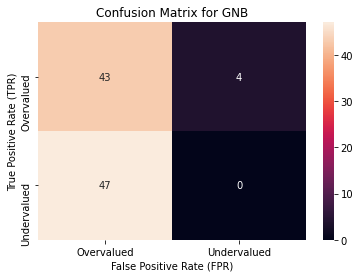

In [127]:
gnb_ros_y_pred = gnb_ros.predict(X_test_ros)
gnb_ros_con_mat = confusion_matrix(y_test_ros, gnb_ros_y_pred)
ax = plt.subplot()
sns.heatmap(gnb_ros_con_mat, annot=True, ax=ax)

ax.set_xlabel('False Positive Rate (FPR)')
ax.set_ylabel('True Positive Rate (TPR)')
ax.set_title('Confusion Matrix for GNB')
ax.xaxis.set_ticklabels(['Overvalued', 'Undervalued'])
ax.yaxis.set_ticklabels(['Overvalued', 'Undervalued'])

[Text(0, 0.5, 'Overvalued'), Text(0, 1.5, 'Undervalued')]

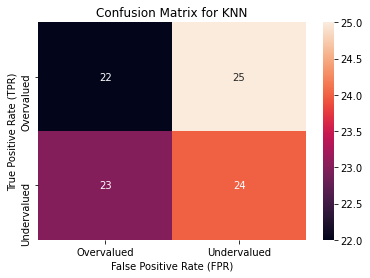

In [128]:
plt.clf() # clear figure
knn_ros_y_pred = knn_ros.predict(X_test_ros)
knn_ros_con_mat = confusion_matrix(y_test_ros, knn_ros_y_pred)
ax = plt.subplot()
sns.heatmap(knn_ros_con_mat, annot=True, ax=ax)

ax.set_xlabel('False Positive Rate (FPR)')
ax.set_ylabel('True Positive Rate (TPR)')
ax.set_title('Confusion Matrix for KNN')
ax.xaxis.set_ticklabels(['Overvalued', 'Undervalued'])
ax.yaxis.set_ticklabels(['Overvalued', 'Undervalued'])

[Text(0, 0.5, 'Overvalued'), Text(0, 1.5, 'Undervalued')]

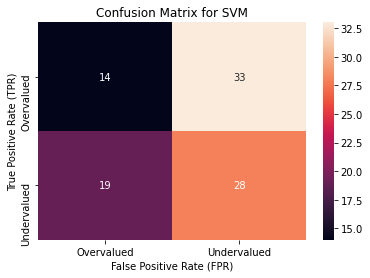

In [129]:
plt.clf() # clear figure
svm_ros_y_pred = svm_ros.predict(X_test_ros)
svm_ros_con_mat = confusion_matrix(y_test_ros, svm_ros_y_pred)
ax = plt.subplot()
sns.heatmap(svm_ros_con_mat, annot=True, ax=ax)

ax.set_xlabel('False Positive Rate (FPR)')
ax.set_ylabel('True Positive Rate (TPR)')
ax.set_title('Confusion Matrix for SVM')
ax.xaxis.set_ticklabels(['Overvalued', 'Undervalued'])
ax.yaxis.set_ticklabels(['Overvalued', 'Undervalued'])

In [130]:
# use Area Under Curve (AUC) to determine which classifier is the best
label_encoder = LabelEncoder()
le_y_test_ros = label_encoder.fit_transform(y_test_ros) # overvalued=0, undervalued=1
y_test_ros = np.asarray(le_y_test_ros).astype('float32')

le_gnb_y_pred = label_encoder.fit_transform(gnb_ros_y_pred) # overvalued=0, undervalued=1
y_pred_ros_gnb = np.asarray(le_gnb_y_pred).astype('float32')
roc_auc_score_gnb = roc_auc_score(y_test_ros, y_pred_ros_gnb)

le_knn_y_pred = label_encoder.fit_transform(knn_ros_y_pred) # overvalued=0, undervalued=1
y_pred_ros_knn = np.asarray(le_knn_y_pred).astype('float32')
roc_auc_score_knn = roc_auc_score(y_test_ros, y_pred_ros_knn)

le_svm_y_pred = label_encoder.fit_transform(svm_ros_y_pred) # overvalued=0, undervalued=1
y_pred_ros_svm = np.asarray(le_svm_y_pred).astype('float32')
roc_auc_score_svm = roc_auc_score(y_test_ros, y_pred_ros_svm)

print('roc_auc_score of GNB =', roc_auc_score_gnb)
print('roc_auc_score of KNN =', roc_auc_score_knn)
print('roc_auc_score of SVM =', roc_auc_score_svm)


roc_auc_score of GNB = 0.4574468085106383
roc_auc_score of KNN = 0.4893617021276595
roc_auc_score of SVM = 0.44680851063829785


In [131]:
print('df_train_drop_na', df_train_drop_na['target'].shape)
print('p_df_train', sdd_df_train.shape)
print('df_test_drop_na', df_test_drop_na['target'].shape)
print('p_df_test', sdd_df_test.shape)

df_train_drop_na (323,)
p_df_train (323, 8)
df_test_drop_na (64,)
p_df_test (64, 8)


In [132]:
X_train, X_test, y_train, y_test = train_test_split(X_test_ros, y_test_ros,test_size=0.1, random_state=42, shuffle=True)

print('X_train.shape:', X_train.shape)
print('X_test.shape', X_test.shape)

label_encoder = LabelEncoder()
le_y_train = label_encoder.fit_transform(y_train) # overvalued=0, undervalued=1
y_train = np.asarray(le_y_train).astype('float32')
le_y_test = label_encoder.fit_transform(y_test)
y_test = np.asarray(le_y_test).astype('float32')

# label_encoder = LabelEncoder()
# y_train = label_encoder.fit_transform(y_train)
# y_train = to_categorical(np.asarray(y_train).astype('float32'))

# y_test = label_encoder.fit_transform(y_test)
# y_test = to_categorical(np.asarray(y_test).astype('float32'))

model = Sequential()
# model.add(Dense(128, activation='relu', input_shape=(8,)))
model.add(Dense(200, activation='relu', input_dim=8))
model.add(Dense(200, activation='relu'))
model.add(Dense(100, activation='relu'))
# model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.001)))
# model.add(Flatten())
model.add(Dropout(0.2))
# model.add(Dense(3, activation='softmax'))
model.add(Dense(1, activation='sigmoid'))
# opt = SGD(lr=0.01, momentum=0.9)
opt = 'rmsprop'
# opt = Adam(lr=0.001)
# opt = 'adadelta'
# opt = 'adam'
# model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
# history = model.fit(X_train, y_train, batch_size=60, epochs=10, verbose=1, validation_split=0.25)
history = model.fit(X_train, y_train, batch_size=8, epochs=4, verbose=1, validation_data=(X_test, y_test))
model.summary()


results_train = model.evaluate(X_train, y_train)
results_test = model.evaluate(X_test, y_test)

print('\n')
print('results_train: ', results_train)
print('results_test:', results_test)


# X_train

X_train.shape: (84, 8)
X_test.shape (10, 8)
Epoch 1/4
11/11 [==============================] - 2s 54ms/step - loss: 0.7009 - accuracy: 0.5358 - val_loss: 1.0719 - val_accuracy: 0.5000
Epoch 2/4
11/11 [==============================] - 0s 17ms/step - loss: 0.6177 - accuracy: 0.7297 - val_loss: 1.1117 - val_accuracy: 0.5000
Epoch 3/4
11/11 [==============================] - 0s 16ms/step - loss: 0.5854 - accuracy: 0.7389 - val_loss: 1.1441 - val_accuracy: 0.6000
Epoch 4/4
11/11 [==============================] - 0s 15ms/step - loss: 0.5702 - accuracy: 0.7485 - val_loss: 1.0532 - val_accuracy: 0.7000
Model: "sequential_44"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_176 (Dense)            (None, 200)               1800      
_________________________________________________________________
dense_177 (Dense)            (None, 200)               40200     
___________________________________________

In [133]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

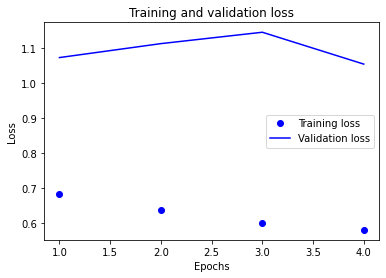

In [134]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

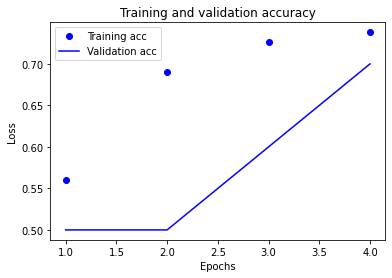

In [135]:
plt.clf()
acc_values = history.history['accuracy']
val_acc_values = history.history['val_accuracy']
plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [136]:
# define neural network model
def baseline_model():
    model = Sequential()
    model.add(Dense(200, activation='relu', input_dim=8))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    opt = 'rmsprop'
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [137]:
# evaluate model with k-fold cross validation
estimator = KerasClassifier(build_fn=baseline_model, epochs=4, batch_size=20, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(df_test_drop_na['target'])
# y_train = to_categorical(df_test_drop_na['target'])
# print(y_train)
r = cross_val_score(estimator, X_test_ros, y_test_ros, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (r.mean()*100, r.std()*100))

Baseline: 64.89% (13.94%)


In [138]:
# make prediction using model
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.55) # increase the threshold for overvalued because I want to get more True positive for Undervalued so that I can buy them and sell for profit later
# y_pred

[Text(0, 0.5, 'Overvalued'), Text(0, 1.5, 'Undervalued')]

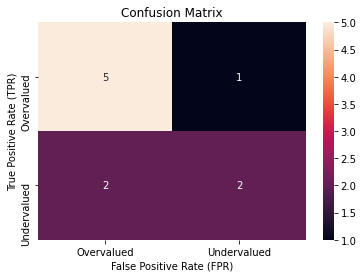

In [139]:
con_mat = confusion_matrix(y_test, y_pred)
ax = plt.subplot()
sns.heatmap(con_mat, annot=True, ax=ax)

ax.set_xlabel('False Positive Rate (FPR)')
ax.set_ylabel('True Positive Rate (TPR)')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Overvalued', 'Undervalued'])
ax.yaxis.set_ticklabels(['Overvalued', 'Undervalued'])

In [140]:
# export model for backend API
model_dir = os.path.join(curr_dir, 'trained_ML_model')

try:
    os.makedirs(model_dir)
except FileExistsError:
    pass

model_name = 'stock_prediction_model_svm.pkl'
# model_name = 'stock_prediction_model_knn.pkl'
# model_name = 'stock_prediction_model_ANN.pkl'


model_path = os.path.join(curr_dir, 'trained_ML_model', model_name)

joblib.dump(svm_ros, model_path)
# joblib.dump(knn_ros, model_path)
# joblib.dump(model, model_path)



['/home/thomas/Desktop/capstone_project/backend/stocks/webscraper/trained_ML_model/stock_prediction_model_svm.pkl']